<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C1_S3-policy-abstraction-and-past/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a third test for an upcoming text book on computational neuroscience from an optimization/learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as a learning algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* **environment**, the (statistical) properties of where an organism lives
* **behaviour**, the statistics of what the organism does
* **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment

This very much is the core of why we are writing this book: we can view pretty much anything happening in the brain (and biology) as being part of a process that brings about improvement in this sense.

___
# Chapter 1.1 Behaviour as a Policy in an Environmental Context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals resulting from the organism's actions in the environment are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies as it becomes difficult to determine whether poor outcomes are due the policy itself or simply bad luck.

___
# **Sequence 1.1.3: Abstracting and Reasoning about policies**

### Objective: In this sequence, we will continue to use the Gridworld environment-organism system from 1.1.1 and our abstraction of the input --> compute --> output process as a policy from 1.1.2 to reason about and compare different policies. At the end of this sequence you will:
* Be able to visualize and compare different policies.
* Appreciate how memory can fit into the input --> compute --> output policy abstraction of sensation, neural computation, and behaviour.

Picture showing receptor/input, brain/compute, musceles/output embedded in the environment feedback loop, this time extended to allow the agent to have some internal state that it propigates into the next time step (some very limited version of 'memory'). (The following is a place holder for our actual image, same as last time, but it's close to the right thing, though not as close as in 1.1.2.)
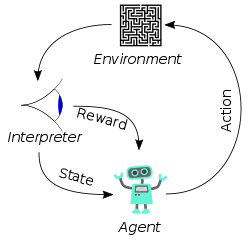

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import copy
from scipy.spatial.distance import cdist
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C1_S3"

Random seed 2021 has been set.
GPU is enabled in this notebook.
Running in colab


In [2]:
# @title More plotting functions

def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles

def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]]) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=250, marker=spec['marker'],
                           color=spec['color'], label=spec['name'])
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()

In [3]:
# @title new definition gridworld board to support multiple agents
class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng = None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_critters = num_critters
    self.num_food = num_food
    self.lifetime = lifetime
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime * self.num_critters)
    # each players move counts down the clock so making this a multiple of the
    # number of critters ensures every player gets an equal number of turns
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][self.num_critters:],
                   rc_idx[1][self.num_critters:])] = -1
    self.active_player = 0
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
      active_player: int
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.active_player = copy(board['active_player'])


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'active_player': copy(self.active_player)}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves, critter):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord.

    Notes:
      Assumes that there is exactly one valid move for each board in the
      batch of boards for the critter type given. i.e. it does't check for
      bounce/reflection on edges or with other critters, or for multiple move
      made on the same board. It only checks for eating food and adds new food
      when appropriate. Invalid moves could lead to illegal teleporting
      behavior, critter duplication, or index out of range errors.

      Currently just prints a message if critter making the move is not the
      active player, could enforce this more strictly if needed.
    """
    if critter-1 != self.active_player:
      # note critter is [1 to num_critter] inclusive so that it can be used
      # directly in where statements on pieces but self.active_player is
      # [0 to numcritter-1] inclusive so that it can be used directly in
      # indexing player lists
      print("Warning! The critter moving is not the expected active player")
    #critters leave their spots
    self.pieces[self.pieces==critter] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    # note critter is +int so need to -1 for indexing
    self.scores[:,critter-1] = self.scores[:,critter-1] + eats_food

    num_empty_after_eat = (self.n_rows*self.n_cols - self.num_food -
                           self.num_critters + 1) # +1 for the food just eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    # put critters in new positions
    self.pieces[moves] = critter
    if np.any(eats_food):
      # add random food to replace what is eaten
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = self.rng.choice(num_empty_after_eat,
                                     size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    self.rounds_left = self.rounds_left - 1
    if not np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1))):
      print(self.pieces.sum(axis=(1,2)))
      print(((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    assert np.all(self.pieces.sum(axis=(1,2)) ==
                  ((self.num_food * -1) + np.sum(np.arange(self.num_critters)+1)))
    # next player's turn
    self.active_player = (self.active_player + 1) % (self.num_critters)


  def get_legal_moves(self, critter):
    """
    Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    # can only move one cell down, up, right, and left from current location
    critter_locs = np.array(np.where(self.pieces == critter))
    legal_offsets = np.stack([
      critter_locs + np.array([np.array([0,  1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, -1, 0])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0,  1])]*self.batch_size).T,
      critter_locs + np.array([np.array([0, 0, -1])]*self.batch_size).T])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))
    legal_offsets = set([tuple(m_) for m_ in legal_offsets])
    # must land on the board and not on another critter
    legal_destinations = np.where(self.pieces <= 0)
    legal_destinations = set([(g, r, c) for
                              g, r, c in zip(*legal_destinations)])
    # legal moves satisfy both these conditions
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, radius, critter):
    """
    Generates a vector representation of the critter perceptions, oriented
    around the critter.

    Args:
      radius: int, how many grid squared the critter can see around it
        using L1  (Manhattan/cityblock) distance

    Returns:
      A batch_size x 2*radius*(radius+1) + 1, giving the values
      of the percept reading left to right, top to bottom over the board,
      for each board in the batch
    """
    # define the L1 ball mask
    diameter = radius*2+1
    mask = np.zeros((diameter, diameter), dtype=bool)
    mask_coords = np.array([(i-radius, j-radius)
      for i in range(diameter)
        for j in range(diameter)])
    mask_distances = cdist(mask_coords, [[0, 0]],
                           'cityblock').reshape(mask.shape)
    mask[mask_distances <= radius] = True
    mask[radius,radius] = False  # exclude the center

    # pad the array
    padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
     (radius, radius)), constant_values=-2)

    # get locations of critters
    critter_locs = np.argwhere(padded_arr == critter)

    percepts = []
    for critter_loc in critter_locs:
      b, r, c = critter_loc
      surrounding = padded_arr[b, r-radius:r+radius+1, c-radius:c+radius+1]
      percept = surrounding[mask]
      percepts.append(percept)
    return(np.array(percepts))

In [4]:
b = GridworldBoard(batch_size=2, n_rows=7, n_cols=7, num_critters=4,
                   num_food=10, lifetime=30)

In [5]:
b.get_init_board_state()

{'pieces': array([[[ 0.,  4.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  2.],
         [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
         [-1.,  0.,  0.,  1.,  0., -1., -1.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1., -1., -1.,  0.,  0.,  3.]],
 
        [[ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0., -1., -1.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  4.,  0.,  0., -1., -1.,  0.],
         [-1., -1.,  3.,  0.,  2.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]),
 'scores': array([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 'rounds_left': array([120., 120.]),
 'active_player': 0}

In [6]:
b.get_legal_moves(1)

{(0, 2, 3), (0, 3, 2), (0, 3, 4), (0, 4, 3), (1, 0, 4), (1, 0, 6), (1, 1, 5)}

In [7]:
b.get_legal_moves(2)

{(0, 0, 6), (0, 1, 5), (0, 2, 6), (1, 4, 4), (1, 5, 3), (1, 5, 5), (1, 6, 4)}

In [8]:
b.get_perceptions(radius=2, critter=1)

array([[ 0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [-2., -2., -2., -2.,  0.,  0.,  0., -2.,  0., -1.,  0., -1.]])

In [9]:
b.execute_moves(([0,1], [2,0], [3,4]), 1)

In [10]:
b.get_state()

{'pieces': array([[[ 0.,  4.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  2.],
         [ 0.,  0.,  0.,  1., -1.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0., -1., -1.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1., -1., -1.,  0.,  0.,  3.]],
 
        [[ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0., -1., -1.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  4.,  0.,  0., -1., -1.,  0.],
         [-1., -1.,  3.,  0.,  2.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]),
 'scores': array([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 'rounds_left': array([119., 119.]),
 'active_player': 1}

In [11]:
b.get_legal_moves(2)

{(0, 0, 6), (0, 1, 5), (0, 2, 6), (1, 4, 4), (1, 5, 3), (1, 5, 5), (1, 6, 4)}

In [12]:
b.execute_moves(([0,1], [1,4], [5,4]), 2)

In [13]:
b.get_state()

{'pieces': array([[[ 0.,  4.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  2.,  0.],
         [ 0.,  0.,  0.,  1., -1.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0., -1., -1.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1., -1., -1.,  0.,  0.,  3.]],
 
        [[ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0., -1., -1.,  0., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  4.,  0.,  0.,  2., -1.,  0.],
         [-1., -1.,  3.,  0.,  0., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]]]),
 'scores': array([[0., 1., 0., 0.],
        [0., 1., 0., 0.]]),
 'rounds_left': array([118., 118.]),
 'active_player': 2}

In [14]:
# @title refactor Monte Carlo for boards that support multiple critters

class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes, )
    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'].copy()
        return terminal_vs
      else:
        pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)

    pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
                                next_board['rounds_left'])
    return vs

In [15]:
# @title make a separate player zoo

class RandomValidPlayer():
  """
  Instantiate random player for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or cornor or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    pis, vs = self.nnet.predict(board['pieces'], board['scores'], board['rounds_left'])
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Player based on the following simple policy:
  If there is any food immediately nearby move towards it,
  otherwise it move randomly.
  """

  def __init__(self, game, fov_radius=2, critter_index=1):
    """

    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 12 if fov_radius = 2)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -2 (out-of-bounds), 0 (empty space), or
        -1 (food).

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] == -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter percieves, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, W, softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      action_probs: dictionary with probabilities of taking each action.
    """
    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is
    # zero otherwise
    x = np.asarray(percept == -1, int)

    output_activations = W @ x
    if np.sum(output_activations > 0):
      # softmax shift by max, scale by temp
      shift_scale_ex = np.exp((output_activations -
                               np.max(output_activations))/softmax_temp)
      sm = shift_scale_ex / shift_scale_ex.sum() #normalized
      probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
      action = self.game.rng.choice(output_struct, p=probs_sm)
      action_probs = {action: prob for action, prob in zip(output_struct, probs_sm)}
    else:
      action = self.game.rng.choice(output_struct)
      action_probs = {direction: 0.25 for direction in output_struct}
    return action, action_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.param_action_from_percept(perceptions[g],
        self.W, softmax_temp=temp)
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs

In [16]:
# @title extend GridworldGame class locally before integrating in shared utils

class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_critters=2, num_food=10,
               lifetime=30, rng=None):
    """
    Initializes an instance of the class with the specified parameters.

    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_critters (int, optional): Number of different agents running around
        on each board in the batch. Default is 2.
      num_food (int, optional): Number of food items. Default is 10.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_critters, num_food,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_critters = num_critters
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a sinlge board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g=0):
    return np.squeeze(np.array(np.where(board['pieces'][g]==1)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 radius=2, figsize=(6,5), title=None,
                 name='Critter'):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # will need to think about how to do this for multiple
      # critters, currently just use rc of first critter in the spec list
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov)
      else:
        fov = plot_fov(fig, ax, critter_specs[0]['rc_loc'], n_rows, n_cols,
                       radius, has_fov, fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_valid_actions(self, board, critter):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter)
    valids = np.zeros((batch_size, n_rows * n_cols))
    for g, r, c in legal_moves:
      valids[g, r * n_cols + c] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Dispaly possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board tiple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parellel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = self.actions_to_moves(actions)
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_critters=self.num_critters,
                         num_food=self.num_food, lifetime=self.lifetime,
                         rng=self.rng)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=batch_size, n_rows=n_rows,
                       n_cols=n_cols, num_critters=self.num_critters,
                       num_food=self.num_food, lifetime=self.lifetime,
                       rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1)}
    critter_locs = np.where(board['pieces'] == critter)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': (0, -1, 0),
        'down': (0, 1, 0),
        'left': (0, 0, -1),
        'right': (0, 0, 1)
    }
    critter_locs = np.where(board['pieces'] == 1)
    probs_arrays = []
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = np.array(offset_dict[direction])
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays.append(prob_array)
    return probs_arrays


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'
    """
    offset_dict = {(0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpyp array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state



In [47]:
# @title widgets refactor for multi-critter
# Interactive Gridworld Game Widgets




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human_'+str(i+1))
        self.any_human_players = True
      else:
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      self.output_and_score = widgets.HBox([self.scoreboard, self.output])
      self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
      if self.collect_fov_data == True:
        # human player collecting data
        self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
      else: # self.collect_fov_data == False:
        # human player not collecting data
        self.final_display = self.no_table_final_display
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_outbput = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index is 0 through num_critter-1, critter value in pieces is
    # index + 1
    active_player_index = old_board['active_player']
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    if (isinstance(self.players[active_player_index], str) and
        'human' in self.players[active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[active_player_index].play(old_board)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[active_player_index] > old_scores[active_player_index]:
      #eating happened
      eating_string = "They ate the food there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[active_player_index],
            new_scores[active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while an artificial player
  plays on an identical board or watching two artificial players play, again
  with identical starting positions (though RNG not synched between the two
  boards, so not like duplicate bridge). We are not going to worry about having
  more than 1 critter type playing in head to head, (maybe we will to talk
  about cooperation... maybe).
  """

  def __init__(self, gridworld_game, init_board=None,
               player0='human', p0_short_name='YOU', p0_long_name=None,
               player1=None, p1_short_name='THEM', p1_long_name=None,
               has_fov=False, radius=2, collect_fov_data=False,
               critter_name='Critter', figsize=(5,4.5),
               has_temp_slider=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player0: object with a play method that takes a board state
        as an argument and returns a move. If none will use a random player
        if the special string 'human' is passed make arrow keys for that player
      player1: same deal as player0, never more than 1 human player
      has_fov: bool, whether or not to display field of view around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    self.player0 = player0
    self.p0_short_name = p0_short_name
    self.p0_long_name = p0_long_name
    self.player1 = player1
    self.p1_short_name = p1_short_name
    self.p1_long_name = p1_long_name
    self.no_human = True
    if self.player0 == 'human':
      assert self.player1 != 'human'
      self.no_human = False
    if self.player1 == 'human':
      assert self.player0 != 'human'
      self.no_human = False
    self.p0_next_move = None
    self.p1_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    self.figsize = figsize
    if player0 is None:
      self.player0 = RandomValidPlayer(self.gwg)
    else:
      self.player0 = player0
    if player1 is None:
      self.player1 = RandomValidPlayer(self.gwg)
    else:
      self.player1 = player1
    self.has_temp_slider = has_temp_slider

    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    #print(self.board_state)

    # both players have same starting board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    if self.has_temp_slider:
      self.sft_slider_label = widgets.Label(value='Softmax Temperature')
      self.sft_slider = widgets.FloatSlider(value=1.0, min=0.05,
                                            max=5.0, step=0.05)
      self.softmax_temp_slider = widgets.VBox([self.sft_slider_label,
                                               self.sft_slider])
    self.output0 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.output1 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='20em', max_width='21em', min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
                                    layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
                                      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
                                      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
                                       layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em', margin='0.6em 0 0 0'))  # 0.6em top margin

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
        self.board_state, g=0, legend_type='separate', figsize=self.figsize,
        has_fov=self.has_fov, radius=self.radius,
        name=self.critter_name, title=self.p0_long_name)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, g=1, legend_type=None,
                             figsize=self.figsize, has_fov=self.has_fov,
                             radius=self.radius, title=self.p1_long_name)
    # player 0 is human
    self.board_buttons_and_output0 = widgets.VBox(
      [self.b_fig0.canvas, self.buttons, self.output0])
    # player 1 is human
    self.board_buttons_and_output1 = widgets.VBox(
      [self.b_fig1.canvas, self.buttons, self.output1])
    # non human players
    self.board_and_output0 = widgets.VBox([self.b_fig0.canvas, self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])

    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    if self.has_temp_slider:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.softmax_temp_slider,
                                               self.start_button])
    else:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.start_button])
    if self.player0 == 'human':
      self.final_display = widgets.HBox([self.board_buttons_and_output0,
                                         self.legend_and_scores,
                                         self.board_and_output1])
    elif self.player1 == 'human':
      self.final_display = widgets.HBox([self.board_and_output0,
                                         self.legend_and_scores,
                                         self.board_buttons_and_output1])
    else: # no human player
      self.final_display = widgets.HBox([self.board_and_output0,
                                          self.legend_scores_start,
                                          self.board_and_output1])
    # initial text outputs
    # if there's a temp slider check who, if anyone uses it
    self.p0_uses_temp = False
    self.p1_uses_temp = False
    if self.has_temp_slider:
      if self.player0=='human':
        pass
      else:
        try:
          _ = self.player0.play(self.board_state, temp=1.0)
          self.p0_uses_temp = True
        except TypeError: pass
      if self.player1 == 'human':
        pass
      else:
        try:
          _ = self.player1.play(self.board_state, temp=1.0)
          self.p1_uses_temp = True
        except TypeError: pass
      if not self.p0_uses_temp and not self.p1_uses_temp:
        with self.output0:
          print("Warning: neither player supports temperature adjustment. "
                "The slider will have no effect.")
    with self.output0:
      if self.no_human == False:
        print('Click a button to start.')
      else:
        print('Click the start button to run the simulation')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Avg. Score:', '--', '--']]
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores'][:,0] #both batches only one critter type
    active_player_index = old_board['active_player']
    self.disable_buttons()
    if self.player0 == 'human':
      a_player0 = which_button
    else:
      if self.p0_next_move is not None:
        a_player0_ = self.p0_next_move
        self.p0_next_move = None
      else:
        with self.output0:
          print("AI is thinking...")
        if self.p0_uses_temp:
          a_player0_, _, _ = self.player0.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player0_, _, _ = self.player0.play(old_board)
      a_player0_ = self.gwg.action_to_critter_direction(old_board,
                                                        active_player_index+1,
                                                        a_player0_)
      a_player0 = a_player0_[0]
    if self.player1 == 'human':
      a_player1 = which_button
    else:
      if self.p1_next_move is not None:
        a_player1_ = self.p1_next_move
        self.p1_next_move = None
      else:
        with self.output1:
          print("AI is thinking...")
        if self.p1_uses_temp:
          a_player1_, _, _ = self.player1.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player1_, _, _ = self.player1.play(old_board)
      a_player1_ = self.gwg.action_to_critter_direction(old_board,
                                                        active_player_index+1,
                                                        a_player1_)
      a_player1 = a_player1_[1]
    self.enable_buttons()

    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, active_player_index+1, [a_player0, a_player1])

    # Try to precompute next AI player move(s) if there are any rounds left
    if self.board_state['rounds_left'][0] > 0:
      if self.player0 != 'human':
        if self.p0_uses_temp:
          self.p0_next_move, _, _ = self.player0.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p0_next_move, _, _ = self.player0.play(self.board_state)
      if self.player1 != 'human':
        if self.p1_uses_temp:
          self.p1_next_move, _, _ = self.player1.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p1_next_move, _, _ = self.player1.play(self.board_state)

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)

    new_scores = self.board_state['scores'][:,0] #both batches one critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "They ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "They ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)

    with self.output0:
      clear_output()
      if self.player0 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row0,col0))
      else:
        print("This player (tried) to move " + a_player0 +
              " and is now at ({}, {}).".format(row0,col0))
      print(eating_string0)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      if self.player1 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row1,col1))
      else:
        print("This player (tried) to move " + a_player1 +
              " and is now at ({}, {}).".format(row1,col1))
      print(eating_string1)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             legend_type=None)
      with self.output0:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[0]))
        print('Resetting the board for another game')
      with self.output1:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[1]))
        print('Resetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = True
    for ii in range(self.gwg.lifetime):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = False

  def disable_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

In [48]:
gwg = GridworldGame(batch_size=1, num_critters=2)
init_board = gwg.get_init_board()
rvp1 = RandomValidPlayer(gwg, critter_index=1)
rvp2 = RandomValidPlayer(gwg, critter_index=2)
compete_igwg = InteractiveGridworld(gwg, init_board=init_board, figsize=(4,4),
                                    critter_names=['RVP1', 'RVP2'],
                                    players=[rvp1, rvp2])
display(compete_igwg.b_fig.canvas)
display(compete_igwg.b_fig_legend.canvas)
clear_output()
display(compete_igwg.final_display)

# 1.1.3.1: Comparing Policies

In the previous sequences we did some implicit comparisons between policies, primarily looking at how effecient different policies were at eating food. However, instead of just looking at overall performance, which can be greatly impacted by the stochasticity of the environment (and the policy) we can use the idea of a policy function together to create visualizations for a more direct and detailed comparison between policies. Specifically we can look at specific environmental contexts (sensory inputs) and see in which contexts policies differ and where they are the same. Let's see how this looks.


Instead of watching a simulation play out in time, we could plot a given food layout and then ask which direction (or direction probabilities) a given policy would select at any of the non-food position on the board. This gives a static snapshot of what a given policy will do across a broad range of different situations. First we will use this to compare to very similar 'Random' policies: 'Random Valid' and 'Random Direction'

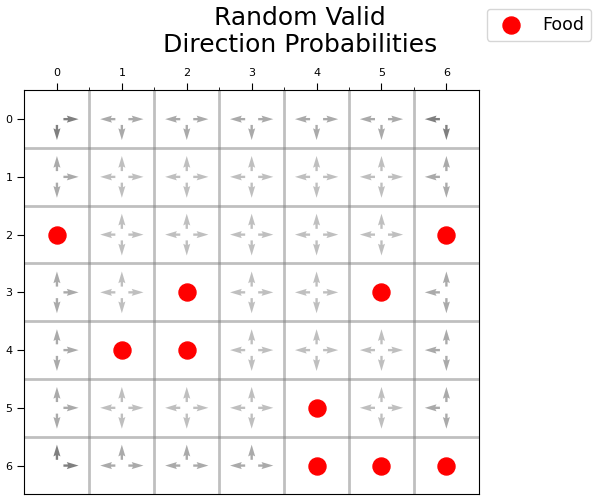

In [60]:
# @markdown Run this cell to see the direction probabilities for a critter that choose a valid move uniformly at random. The darkness of each arrow, *alpha level* in plotting lingo, is proportional to the probility of moving in that direction.
gwg = GridworldGame(batch_size=2, n_cols=7, n_rows=7, num_critters=1)
init_state = gwg.get_init_board()
rvp = RandomValidPlayer(gwg, 1)
gwg.plot_moves(init_state, rvp, title="Random Valid\nDirection Probabilities")
plt.show()

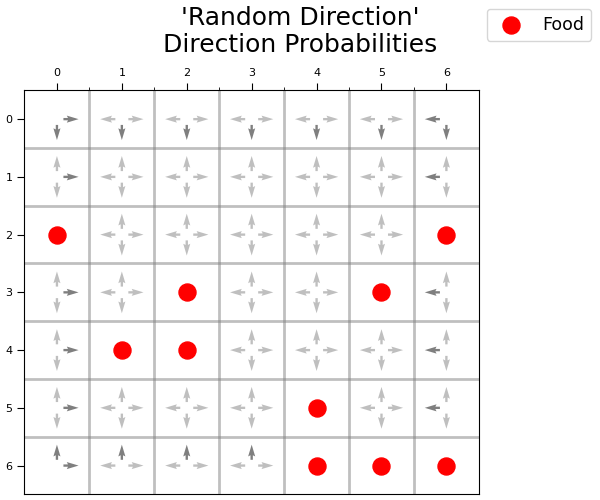

In [61]:
# @markdown Run this cell to see the direction probabilities of a critter that tries to move up, down, left or right with uniform probability, but then sometimes 'bounces' off the edges.
rdp = RandomDirectionPlayer(gwg)
gwg.plot_moves(init_state, rdp, title="'Random Direction'\nDirection Probabilities")
plt.show()

**Question:** Although 'Random Valid' and 'Random Direction' policies are very similar there are some slight differences, what are they, and in which contexts do they occur?
[Answer](## "Along the edges, 'Random Direction' is more likely, 1/2 chance to move away from the edge compared to 'Random Valid' which only has a 1/3 chance of moving away from the edge.")

Next lets compare the heavily optimized and omniscient GW7x7-10-30 policy (A combination of Deep Reinforcement Learning and Monte Carlo search), with the 'Parameterized Weights' policy (linear weights from a limited perceptual field determine the probability of movement direction.)

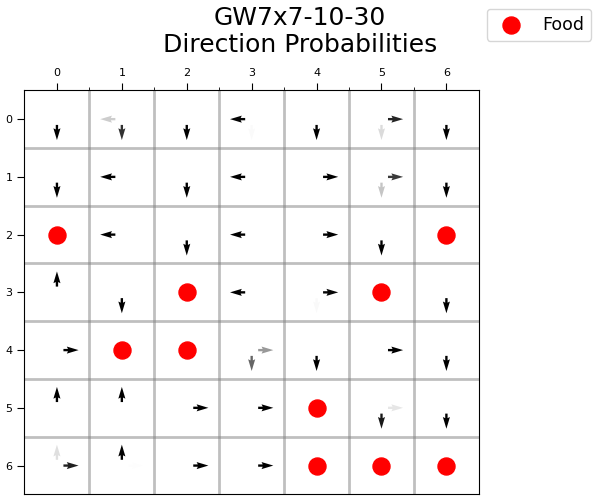

In [63]:
# @markdown Run this cell to see the direction probabilities for GW7x7-10-30's.

pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=3,
                            default_rollouts=80, default_temp=0.02)


#grab the saved model from the repo or where it ends up being hosted
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

# load the saved model
pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

gwg.plot_moves(init_state, mcp, title="GW7x7-10-30\nDirection Probabilities")
plt.show()

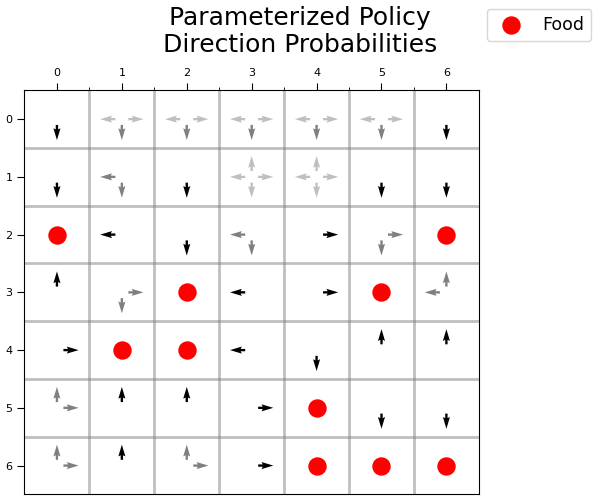

In [64]:
# @markdown Run this cell to see the direction probabilities of the 'Parameterized Weights' policy.

ppp = PerceptParamPlayer(gwg)
gwg.plot_moves(init_state, ppp, title="Parameterized Policy\nDirection Probabilities")
plt.show()

It looks like the parameterized policy and GW7x7-10-30 are very similar. Instead of having to scroll back and forth to compare these policies let's plot the two policies side by side on the same board and see where they are the same, and where they differ.

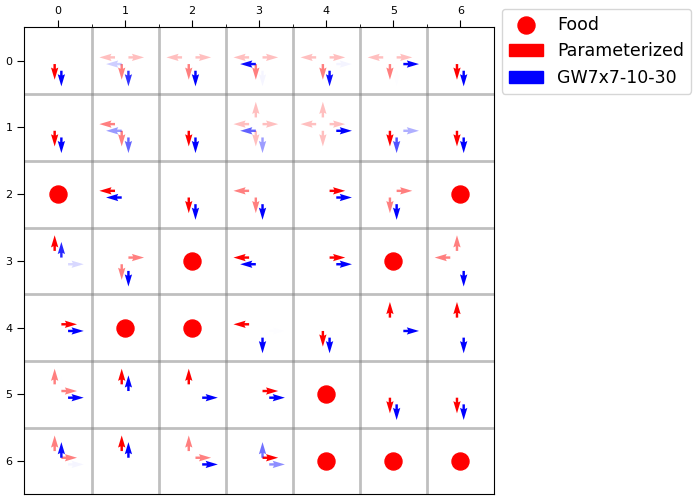

In [65]:
# @markdown Run this cell compare 'Parameterized Wieghts' and 'GW7x7-10-30' side by side.
gwg.plot_moves(init_state, player0=ppp, g=0, player1=mcp, p0_name='Parameterized', p1_name='GW7x7-10-30', figsize=(7,5))
plt.show()

Now lets compare these two policies.
Questions:
1.   Looking at grid cells (5,3), (4,4) the two policies are very similar, why?
2.   Looking at grid cell (1,3) the policies differ, why?
3. Looking at grid cells (4,3) and (4,5) the polcies differ again but for different reasons, why?

Maybe use chatgpt box here... how?

[Answer](## "In some cells, like (5,3) and (4,4) the two policies behave identically, efficiently moving to nearby food, the parameterized policy acts on nearby relevant info in the same way as the more complicated policy in these cases. In other cells like (1,3) the two polcies are very different and this can be chalked up to the fact that the parameterized policy has limited perception. In this cell (1,3) it's perceptual feild is empty, in contrast GW7x7-10-30 'sees' the whole board and so knows how to move toward food. However in yet other cells, like (4,5) some very interesting differences appear. The parameterized policy is inherently a short term maximizer, and so it move immediately towards the food at (6,5). In contrast GW7x7-10-30 has learned to sometimes forgo immediate reward to 'set itself up' for a very effienct serries of moves, and so moves to (5,6) after which it will be able to make (at least) four eating moves in a row. (All this only true for SEED = 2021, otherwise different board position to analyze).")



While there are sets of parameters that will allow the parameterized player to behave like GW7x7-10-30 in some circumstances, the basic archetecture of the 'Parameterized Weights' policy is not sufficinetly rich to match GW7x7-10-30 in all circumstances.

In this case it is because choosing a direction based on a linear combination of its perceptual inputs, this enables it to implement a policy roughly equivalent to moving towards the center of high density patches of food. In contrast, the non-linear archetecture of GW7x7-10-30 means that it can both move towards the edges of high denisty patches of food *and then* move efficiently through the patch, effectively implementing a more sublte logic that takes into account future moves.

# 1.1.3.2: Memory

So far all the agents we have looked at have made their moves based on their immediate perceptions of the environment. However, in many cases taking into account what has happened in the past drastically improve the effeciency of a policy. GW7x7x-10-30's omnisceince limits the scope for memory to improve the policy, but for all the other agents, especially the simple random agent, the incorporation of even very simple and limited memory can beneficial.

Let's make modified version of the random player that remembers which grid cell it was in last round and uses this to avoid immediate backtracking. Note that 'memory' in a broad sense (and in simple cases like this this it is easy to see) need not be implemented exclusively as an internal neural state, but might also be wholly or partially embedded in the physics of an organisms movement, i.e. 'memory' could manifest as an orientation relative to the direction of movement with new directions chosen relative to this orientation. (Let the physics do the work when it can!). Regardless of the mechanism, some awareness of the past can be beneficial.

Let's implement this 'Memory Improved Random Valid' policy.

In [67]:
# @markdown Run this cell to define the tests for the coding exercise below.

import numpy as np

def test_memory_reset(game):
  player = RandomValidMemoryPlayer(game)
  board = game.get_init_board()
  board['rounds_left'] = np.zeros(board['rounds_left'].shape)
  player.last_locs = [0]
  player.play(board)
  assert player.last_locs is None, "Memory was not reset after the last round!"
  return "Memory reset test passed!"

def test_memory_update(game):
  player = RandomValidMemoryPlayer(game)
  board = game.get_init_board()
  expected_last_loc = game.moves_to_actions(np.where(board['pieces'] == player.critter_index))
  player.play(board)
  assert np.array_equal(player.last_locs, expected_last_loc), "Memory was not updated correctly!"
  return "Memory update test passed!"

def test_invalidating_old_moves(game):
  player = RandomValidMemoryPlayer(game)
  # Define an initial board state
  board = {
  'pieces': np.zeros((1, 7, 7)),
  'scores': np.array([0]),
  'rounds_left': np.array([2]),
  'active_player': 0
  }
  # Set a starting position for the player (for example, center of the board)
  board['pieces'][0, 3, 3] = 1
  #play the board
  _, _, probs = player.play(board)
  # Manually set this starting position to last_locs
  player.last_locs = [3 * 7 + 3]  # This translates (3,3) to a flattened index
  # Ensure the player doesn't move back to the previous position
  assert probs[0][player.last_locs[0]] == 0, "Backtracking was not invalidated!"
  return "Invalidating old moves test passed!"

def test_probabilities(game):
    player = RandomValidMemoryPlayer(game)
    board = game.get_init_board()
    _, _, probs = player.play(board)
    assert np.isclose(np.sum(probs), 1), "Probabilities don't sum up to 1!"
    return "Probabilities test passed!"

def test_valid_actions(game):
    player = RandomValidMemoryPlayer(game, critter_index=1)
    board = game.get_init_board()
    actions, _, _ = player.play(board)
    valids = game.get_valid_actions(board, player.critter_index)
    for action in actions:
        assert valids[0][action] == 1, f"Invalid action: {action}"
    return "Valid actions test passed!"

def run_all_tests():
    test_game = GridworldGame(batch_size=2,
                              n_rows=7, n_cols=7, num_critters=1,
                              num_food=10, lifetime=30)
    tests = [test_memory_reset, test_memory_update, test_invalidating_old_moves,
             test_probabilities, test_valid_actions]
    for test_func in tests:
        result = test_func(test_game)
        print(result)


def run_all_tests():
  test_game = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_critters=1,
                            num_food=10, lifetime=30)
  tests = [test_memory_reset, test_memory_update, test_invalidating_old_moves,
           test_probabilities, test_valid_actions]
  for test_func in tests:
    result = test_func(test_game)
    print(result)

In [68]:
################################################################################
# TODO for students: Complete the lines with ...  to stop the critter from
# moving to cells it was in immediately before, and to update the memory of
# where the critter was last round. Then comment out the line below and see if
# your code runs and passes the code checks.
raise NotImplementedError("Exercise: limit backtracking with memory")
################################################################################

class RandomValidMemoryPlayer():
  """
  Instantiate random player that uses memory for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.last_locs = None


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    #invalidate old moves using memory of where critter last was
    if self.last_locs is not None:
      valids[(np.arange(batch_size), self.last_locs)] = ...
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    action_size = n_rows * n_cols
    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    # update memory
    rounds_left = board['rounds_left'][0]
    if rounds_left > 1:
      self.last_locs = self.game.moves_to_actions(np.where(board['pieces']==...))
    else:
      # last move of the game reset memory for next game
      self.last_locs = ...
    return np.array(a), a_1hots, probs

run_all_tests()

NotImplementedError: ignored

In [69]:
# to_remove solution

class RandomValidMemoryPlayer():
  """
  Instantiate random player that uses memory for GridWorld
  """


  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.last_locs = None


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index)
    #invalidate old moves using memory of where critter last was
    if self.last_locs is not None:
      valids[(np.arange(batch_size), self.last_locs)] = 0
    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)
    action_size = n_rows * n_cols
    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    # update memory
    rounds_left = board['rounds_left'][0]
    if rounds_left > 1:
      self.last_locs = self.game.moves_to_actions(
          np.where(board['pieces']==self.critter_index))
    else:
      # last move of the game reset memory for next game
      self.last_locs = None
    return np.array(a), a_1hots, probs

run_all_tests()

Memory reset test passed!
Memory update test passed!
Invalidating old moves test passed!
Probabilities test passed!
Valid actions test passed!


In [37]:
# To figure out this exercise you might want/need to play around with and think
# about what self.last_locs should look like, and what valids does look like.
# To do that run this cell and then hack around a bit
gwg_explore = GridworldGame(batch_size=1, n_rows=7, n_cols=7, num_critters=1,
                            num_food=10, lifetime=30,
                            rng=np.random.default_rng(seed=5))
init_board = gwg_explore.get_init_board()
print('Initial board state')
print(init_board)
valids = gwg_explore.get_valid_actions(init_board, critter=1)

print('\n-----------------------------------------------------')
print('Human friendly (text) display of the board:')
gwg_explore.display(init_board, g=0)

print('\n-----------------------------------------------------')
print('np.where critter location format:')
display(np.where(init_board['pieces']==1))


print('\n-----------------------------------------------------')
print('Flattened index representation of critter location')
display(gwg_explore.moves_to_actions(
          np.where(init_board['pieces']==1)))


print('\n-----------------------------------------------------')
print('Human friendly (text) display of the valid moves')
gwg_explore.display_moves(init_board, g=0)

print('\n-----------------------------------------------------')
print('Array representation of Valids')
print('Shape of valids:' +str(valids.shape))
print(valids)


Initial board state
{'pieces': array([[[-1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0., -1.,  0.,  0.,  0., -1.,  0.],
        [-1.,  0.,  0.,  0., -1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.]]]), 'scores': array([[0.]]), 'rounds_left': array([30.]), 'active_player': 0}

-----------------------------------------------------
Human friendly (text) display of the board:
   0 1 2 3 4 5 6 
-----------------------
0 |X - X - - - - |
1 |- - - - - - 0 |
2 |- - - - - - X |
3 |- X - - - X - |
4 |X - - - X X - |
5 |- - - - - - - |
6 |- - - - X - X |
-----------------------
Rounds Left: 30.0
Score: [0.]

-----------------------------------------------------
np.where critter location format:


(array([0]), array([1]), array([6]))


-----------------------------------------------------
Flattened index representation of critter location


array([13])


-----------------------------------------------------
Human friendly (text) display of the valid moves
  
possible moves
   0 1 2 3 4 5 6 
-----------------------
0 |- - - - - - 0 |
1 |- - - - - 0 - |
2 |- - - - - - 0 |
3 |- - - - - - - |
4 |- - - - - - - |
5 |- - - - - - - |
6 |- - - - - - - |
-----------------------

-----------------------------------------------------
Array representation of Valids
Shape of valids:(1, 49)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


Why does `pieces` represent the board as a batch of 7x7 arrays, but `valids` give a boolean (or mask) based index for a flattened 7x7 array?!? How does `valids` relate to directions relative to the organism's location?!? Why is the organism's location represented both as a triple of arrays by the output of `np.where` but also as a flattened index of the 7x7 array?!?

The (unfortunate?) reality is that certain types of computation and reasoning are much more efficient using different data structures and representations. So much so that it is often well worth the effort of mainting and translating between a variety of representations. (In fact the transformation of inputs into internal representations well suited to specific computations is a critical aspect of neural processing that we will discuss later in this book.) So far in this book we've worked hard to abstract away from the details of translation between representations, and in general we will continue to do so to provide a streamlined presentation of the material. However, we would be doing you a grave dis-service if we didn't provide at least some awareness of the (often tedious) book keeping required to implement learning algorithms. Hence the coding exercise above, and this discussion.

Now that we've got our memory enhanced random drifter, let's see how it compares to memoryless random drifting.

In [70]:
# @title Random Drifting with and without memory
# @markdown **Run the cell** and press start to compare the random + memory policy we defined above with memoryless random drifting.

gwg = GridworldGame(batch_size=2,
                    n_rows=7, n_cols=7,
                    num_critters=1,
                    num_food=10,
                    lifetime=30,
                    rng=np.random.default_rng(seed=9))
rvp = RandomValidPlayer(gwg)
rvmp = RandomValidMemoryPlayer(gwg)
h2h_igwg = Head2HeadGridworld(gwg, player0=rvp, p0_short_name='RANDOM',
                              p0_long_name='Random Valid\nPolicy',
                              player1=rvmp, p1_short_name='MEMORY',
                              p1_long_name='Random + Memory\nPolicy',
                              figsize=(2.4,3.0), has_fov=False, radius=2,
                              critter_name='$\mathit{Critter}$')
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

How much more efficient was drifting with memory? Why? How much more effecient should we expect the elimination of backtracking to make random drifting. Answering this question exactly is hard, but a rough upper bound on the improvement can be reasoned through relatively easily.

1) The gains in efficiency largely come from the avoidances of backtracking
2) A Random mover spends on average more than 1/4 of it's time backtrakcing. To figure out precisely how much backtracking we'd need to know the amount of time it spent in corners and on the edges (where the probability of backtracking is greater relative to the middle), but more than 1/4 is good enough for now.
3) Assume that when not backtracking the 'Random Valid' and 'Random Valid + Memory' policies are equally likely to consume food. (The probably isn't exactly true, but close enough. For a rough answer.)
4) If 'Random Valid' policy is throwing away at least 1/4 of moves on direct backtracking, then the average score of 'Random Valid + Memory' should be at least 1.33 times greater.

Run simulations above until it looks like the the average scores have roughly stabalized. How much better is 'Random Valid + Memory' compared to 'Random Valid', more, less or about 1.33 times better?

Reasoning exercises like this can serve as both a sanity check of your intuitions against data and your data (including collection and display) against your intuitions.

# 1.1.3.3 Competing Policies
So far when we have compared policies/agents, each agent has been happily going about it's business in it's own personal private Gridworld universe and we have compared the efficiency of each agent acting in isolation. However, a key aspect of life for many (most/all?) organisms is competition over limited resources critical to replication, e.g. food, viable nesting sites, mating opportunities. Competition can be between con-specifics, or organisms of other species (e.g. prey and predator species compete to see who get's eaten and who goes hungry). To get a sense of how competition can affect things we now modify the Gridworld to have two different organisms that each take turns moving (and eating if they land on food). Organisms are not allowed to move on a space already occupied by another organism (much like they are not allowed to move off the board). Let's see what happens now when the random drifter and the memory random drifter compete directly in a shared environment.

In [41]:
# @title Memory vs. Drifting direct competition
# @markdown Don't worry about how this code works – just **run this cell** and press the start button some direct competition between two simple strategies.
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_critters=2, num_food=10,
                    lifetime=30, rng=rng)
init_board = gwg.get_init_board()
compete1_igwg = InteractiveGridworld(gwg, init_board=init_board, figsize=(4,4),
                                     critter_names=['Random', 'Memory'],
                                     players=[RandomValidPlayer,
                                              RandomValidMemoryPlayer])
display(compete1_igwg.b_fig.canvas)
display(compete1_igwg.b_fig_legend.canvas)
clear_output()
display(compete1_igwg.final_display)

In [ ]:
rng = np.random.default_rng(seed=420)
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_critters=2, num_food=10,
                    lifetime=30, rng=rng)
init_board = gwg.get_init_board()
compete2_igwg = InteractiveGridworld(gwg, init_board=init_board, figsize=(4,4),
                                     critter_names=['Random', 'Memory'],
                                     players=[PerceptParamPlayer,
                                              MonteCarloBasedPlayer])
display(compete2_igwg.b_fig.canvas)
display(compete2_igwg.b_fig_legend.canvas)
clear_output()
display(compete2_igwg.final_display)

Now that you've seen what this limited field of perception looks like it's time for a micro science question:

**Are *Fishy's* perceptions of the environment predictive of whether or not they will eat food?**

Make a guess. Think about how you would prove to yourself whether your guess is right. There are lots of ways to validate your guess; let's explore one of them right now. Our first step is to **observe** the behavior and **collect data**! Any way of validating your guess that purports to be science (in the modern sense) will start this way, with data. However, keep in mind, there are other approaches and modes of thinking out there. For example, a theorist or mathematician might bypass observations and data, diving straight into deductions based on abstract assumptions. But, that's not going to be our approach here and now (though we will borrow it occasionally throughout the book).

In [ ]:
# @title Observations of Random Movement with Limited Perception
# @markdown Don't worry about how this code works – just **run this cell**, then press the start button and watch the data collection happen.
rng = np.random.default_rng(seed=2023)
gwg = GridworldGame(1, 7, 7, 10, 30, rng=rng)
record_igwg = InteractiveGridworld(gwg, has_fov=True, collect_fov_data=True,
                                   player=None, critter_name='$\mathit{Fishy}$',
                                   figsize=(4,4))
display(record_igwg.b_fig.canvas)
display(record_igwg.b_fig_legend.canvas)
clear_output()
display(record_igwg.final_display)

Start by running two or three simulations to collect 'adequate' data for analysis.

**Thought/Bonus/Further Reading: How much data is truly 'enough'?:**

Entire methodologies have been developed to answer this critical question.  In a hypothesis testing framework, power analysis is used to determine optimal sample size by considering the strength an effect to be detected and the desired statistical power of the test. In an ML framework, notions of Empirical Risk Minimization inform the amount of data needed. In a Bayesian context, assessment of convergence of posterior distributions of parameters indicates whether incoming data is helping (or continues to help) improve those parameter estimates.


Now that we have some observations, let's put them in a structure we can easily work with. Here's how the data looks:

In [ ]:
data = record_igwg.fov_eat_table_data
display(data)

When analyzing data we ***always*** plot the data before doing ***anything*** else. Which visualization to start with is a more subjective question, though histograms and scatter plots are often good starting points. In this case we'll go for a [histogram](## "In a histogram each bin represents a range of values, and the height of the bar shows the frequency (number of data points observed) within that range.") of the two distributions of number of food items perceived conditional on whether eating happened immediately afterward or not. Before you run the code below to generate the picture, think about what it might look like.

In [ ]:
# If data collection step was skipped above use this data instead
if np.all(data == np.zeros(data.shape)):
  print("You haven't collected any data, using canned data instead.")
  data = np.array(
    [[10., 22., 11.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
     [ 0.,  1.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

# Unpack the contingency table into a list of raw observations
# A flat array of perception values before 'Not Eating' events
not_eating = np.repeat(range(len(data[0])), data[0].astype(int))
# A flat array of perception values before 'Eating' events
eating = np.repeat(range(len(data[0])), data[1].astype(int))

# Create histograms
fig_hist, (ax1_hist, ax2_hist) = plt.subplots(2, 1, sharex=True, sharey=True,
                                              figsize=(8,6))
# Define bin edges
nonzero_col_index = np.where(data > 0)[1]
bin_edges = np.arange(-0.5, np.max(nonzero_col_index) + 1.5, 1)
# Plot Histograms
ax2_hist.hist(not_eating, bins=bin_edges, color='blue', alpha=0.7, rwidth=0.9)
ax1_hist.hist(eating, bins=bin_edges, color='orange', alpha=0.7, rwidth=0.9)
ax1_hist.set_title('Distribution of Food Items in Percept before Eating and Not Eating',
                   fontsize=14)
ax1_hist.set_ylabel('Before\nEating Counts', fontsize=12)
ax2_hist.set_ylabel('Before\nNot Eating Counts', fontsize=12)
ax2_hist.set_xlabel('Number of Food Items in Perceived', fontsize=12)
remove_ip_clutter(fig_hist)
fig_hist.tight_layout()
plt.show()

These histograms reveal differences in the distribution of perceived food items immediately prior to 'Eating' and 'Not Eating' events. 'Not Eating' is more frequently observed, especially when fewer food items are perceived beforehand. This should not be surprising, fishy sees 12 spots, a small number of which typically carry food. On the other hand, 'Eating' events, although less common, tend to occur more often when more food items are perceived. These initial observations hint that the perception of food may be predictive of eating.

To get at our question — does perceiving food predict eating more directly? — we will next plot the proportion of times eating followed for the different numbers of food items perceived. Again, to visualize what the plot might look like before you run the following code.

In [ ]:
################################################################################
# TODO for students: Replace ... in the line:
# prob_eating plot_data[...] / plot_data.sum(axis=...)
# Comment out or remove this next lines.
raise NotImplementedError("Exercise: plot proportion of eating")
################################################################################

# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[...] / plot_data.sum(axis=...)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
# Display the plot
plt.show()

In [ ]:
# to_remove solution
# Calculate the probability of eating given the amount of food perceived
# for food amounts with non-zero observations
non_zero_cols = np.where(data.sum(axis=0) > 0)[0]
plot_data = data[:, non_zero_cols]
prob_eating = plot_data[1,:] / plot_data.sum(axis=0)
# Create a figure and axis for the plot
fig_prop, ax_prop = plt.subplots()
# Plot the probabilities
ax_prop.plot(np.arange(len(data[0]))[non_zero_cols], prob_eating, marker='o')
# Set the title and labels
ax_prop.set_title('Proportion of Eating Events by\nAmount of Food Perceived Prior')
ax_prop.set_xlabel('Number of Food Items Perceived')
ax_prop.set_ylabel('Proportion where Eating Follows')
remove_ip_clutter(fig_prop)
fig_prop.tight_layout()
# Display the plot
plt.show()

In this plot, it appears that the proportion of eating events increases as the amount of food perceived immediately prior increases. This suggests that the amount of food perceived could indeed predict eating behavior. However, this is just a visualization and not a formal test of a causal relationship. Later in the book we will review how to formally assess predictiveness through statistical models, such as logistic regression, which would be suitable for this case of predicting a binary outcome (eating vs. not eating) from a predictor variable (or variables) like the amount of food perceived.

Bonus: Think about what makes a good predictor variable:

We observed and recorded the total number of food items percieved and used that as our 'predictor' variable in the analysis and visualizations above. Do you think there are other aspects of *Fishy's* perceptions, beyond just the total number of food items perceived that could be used to make better predictions about the amount of food eaten?(Hint: Could the predictor variable consider the relative location of food items within the perceptual field?) [Solution.](## "In terms of predicting immediate eating, really only the four grid cells immediately adjacent to *fishy* can have any bearing on whether eating will happen in the next round, so the sum of food items just in those four cells would be a much better predictor. Note that we haven't gotten into what 'better' means yet for a predictor so this question is kind of ill formed, but we will eventually and what makes a good predictor is good thing to start thinking about right away.")

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.1.2.2: Perception Guiding Actions is a Policy

We've seen that even in the case of random drifting, perceptions of the environment can carry information about import things like whether or not eating will happen. Now, we're going to hook this perceptive field up to some highly abstracted 'muscles' by making a simple set of rules that translate *Fishy's* perceptions into a choice of actions (one of up, down, left, right).

Before we attempt this we need to understand the form of *Fishy's* perceptions. We recorded some of these in the previous section, what do they look like?

In [ ]:
# 'record_igwg' is an instance of an InteractiveGridworld object
# that we ran in the cell above to record data
print(f"Type of 'record_igwg': {type(record_igwg)}")

In [ ]:
# 'record_igwg' has a 'percept_eat_records' attribute. This is a list of all
# the records from the games played by the InteractiveGridworld object since it
# was instantiated.
print(f"Type of 'percept_eat_records': {type(record_igwg.percept_eat_records)}")
# The length of 'percept_eat_records' should be 30 times the number of times you
# ran the simulation.
print(f"Length of 'percept_eat_records': {len(record_igwg.percept_eat_records)}")

Now, let's inspect what a record looks like:

In [ ]:
# If we didn't collect any data we'll use some canned data
if len(record_igwg.percept_eat_records) < 2:
  record_igwg.percept_eat_records.append(
    {'perception': np.array(
        [-1., -1.,  0., -2., -1.,  0., -2., -2., -1.,  0., -2.,  0.]),
     'state': {
      'pieces': np.array(
          [[[ 0.,  0.,  0., -1., -1.,  0., -1.],
            [ 0.,  0., -1.,  0., -1., -1.,  0.],
            [ 0.,  0.,  0.,  0., -1.,  0.,  1.],
            [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
            [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
            [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
            [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
      'scores': np.array([0.]),
      'rounds_left': np.array([30.])},
     'did_eat': False})
  record_igwg.percept_eat_records.append(
    {'perception': np.array(
        [ 0.,  0.,  0., -2.,  0., -1., -2., -2., -1.,  0., -2.,  0.]),
     'state': {
        'pieces': np.array(
            [[[ 0.,  0.,  0., -1., -1.,  0., -1.],
              [ 0.,  0., -1.,  0., -1., -1.,  0.],
              [ 0.,  0.,  0.,  0., -1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0., -1.]]]),
        'scores': np.array([0.]),
        'rounds_left': np.array([29.])},
     'did_eat': False})

# Let's examine the first two elements of the list.
# What type is the record?
print(f"Type of first record: {type(record_igwg.percept_eat_records[0])}")
# What does the first one look like?
print('----------------------------------')
display(record_igwg.percept_eat_records[0])
# What does the second one look like?
print('----------------------------------')
display(record_igwg.percept_eat_records[1])

It looks like the first two elements of the list are dictionaries, and, as it turns out, all elements share this structure. These dictionaries contain relatively self-descriptive keys. Let's walk through the structure of these records element by element.

* `perception`: This is a 12-element array with -2's denoting areas where the perceptual field lies outside the boundaries of the Gridworld, 0's indicating empty spaces on the grid, and -1's marking food locations.
* `state`: This is another dictionary representing the state of the board at the time of the perception. The `pieces` element of `state` is a 7x7 array depicting the grid positions of the organism (1), the food (-1's), and the empty spaces (0's). The `scores` and `rounds_left` elements describe exactly what their names suggest.
* `did_eat`: This is a boolean indicator that is `True` when eating occurred in the round immediately following the perception and `False` when eating did not occur.

Can you see how the perceptive field, as defined below, is overlaid on the 7x7 array to generate a perceptions?

In [ ]:
# define the L1 ball mask the determines what an organism perceives
# Perception radius for an organism
radius = 2
# Grid size to encompass perception 'circle', include center point
diameter = radius*2+1
# Empty grid (initially all False)
mask = np.zeros((diameter, diameter), dtype=bool)
# Relative coordinates for grid points, center at (0,0)
mask_coords = np.array([(i-radius, j-radius)
  for i in range(diameter)
  for j in range(diameter)])
# Calculate cityblock distance from each point to center
mask_distances = cdist(mask_coords, [[0, 0]], 'cityblock').reshape(mask.shape)
# Mark points within perception radius as True
mask[mask_distances <= radius] = True
# Exclude center point (organism itself)
mask[radius,radius] = False
print('--------------------Perceptive Field---------------------------')
display(mask)
print('\n--------------------Environment-------------------------------')
display(record_igwg.percept_eat_records[0]['state']['pieces'])
print('\n--------------------Perception--------------------------------')
display(record_igwg.percept_eat_records[0]['perception'])

The indices of the perception array correspond to the spaces around the organism as follows.

In [ ]:
numbered_mask = np.ones(mask.shape) * -1
numbered_mask[mask] = range(mask.sum())
display(numbered_mask)

Note that Fishy lacks an orientation in relation to the Gridworld; all directions are defined in absolute or cardinal terms: 'up', 'down', 'left', and 'right'. So another way of thinking about the perception vector is as follows:

In [ ]:
# in human readable terms the perception is organized as
human_readable_percept_structure = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
print(human_readable_percept_structure)

Now that we understand what a perception looks like, let's build a function that accepts a perception as input and outputs one of four possible moves. To start, we'll create a simple function based on the following logic: if any is food immediately adjecent, *Fishy* moves towards it; otherwise *Fishy* moves randomly.


In [ ]:
# @markdown Run this cell to set up the tests for the code exercise below
def test_action_from_perception(test_func):
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']

  # Test when there's no food nearby
  perception = np.zeros(12)
  assert test_func(perception) in ['up', 'down', 'left', 'right']

  # Test when there's food to the near up
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  assert test_func(perception) == 'up'

  # Test when there's food to the near down
  perception = np.zeros(12)
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) == 'down'

  # Test when there's food to the near left
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  assert test_func(perception) == 'left'

  # Test when there's food to the near right
  perception = np.zeros(12)
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) == 'right'

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near up')] = -1
  perception[percept_struct.index('near right')] = -1
  assert test_func(perception) in ['up', 'right']

  # Test when there's food in multiple nearby directions
  perception = np.zeros(12)
  perception[percept_struct.index('near left')] = -1
  perception[percept_struct.index('near down')] = -1
  assert test_func(perception) in ['down', 'left']

  print('Congrats, Tests Passed')

In [ ]:
################################################################################
# TODO for students: Complete the lines with ...  to identify directions where
# food is nearby and then randomly choose between directions with nearby food
# if food is nearby. Then comment out the line below and see if your code
# runs and passes the code checks.
raise NotImplementedError("Exercise: make actions depend on perception")
################################################################################


# to_remove solution
def simple_action_from_percept(percept, rng=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == ...]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return rng.choice(...)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return rng.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

In [ ]:
# to_remove solution
def simple_action_from_percept(percept, rng=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # Defines directions corresponding to different perception indices
  direction_struct = [
    'None', 'None', 'up', 'None',
    'None', 'left', 'right', 'None',
    'None', 'down', 'None', 'None']
  # these are what count as nearby in the percpt
  nearby_directions = ['near up', 'near down', 'near left', 'near right']
  # Get the corresponding indices in the percept array
  nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
  # Identify the directions where food is located
  food_indices = [index for index in nearby_indices if percept[index] == -1]
  food_directions = [direction_struct[index] for index in food_indices]
  if len(food_directions) > 0:  # If there is any food nearby
    # If there is any food nearby randomly choose a direction with food
    return rng.choice(food_directions)  # Move towards a random one
  else:
    # If there is no food nearby, move randomly
    return rng.choice(['up', 'down', 'left', 'right'])

test_action_from_perception(simple_action_from_percept)

Congratulations, you've just implemented your first policy function. Any  function, like this one, that takes perceptions as inputs and outputs actions, in the context of an environmental feedback loop is called a ***policy***.

Also, observe how we use a test here to check if your code does the right things. When writing good, high quality, code, most programmers write such tests for their own code. Writing more lines for the tests than the code being tested is perfectly standard. The number, breadth, and quality of the tests is what ultimately defines how much you can trust your code!

Now that we have a policy let's see how it compares to random drifting.

In [ ]:
# @title A Simple Rule Based Policy Versus Random Drifting
# @markdown Don't worry about how this code works – just **run the cell** and press start to compare the policy we defined above with random drifting.

class SimpleRulePlayer():
  """
  A Player based on the following simple policy:
  If there is any food immediately nearby move towards it,
  otherwise it move randomly.
  """

  def __init__(self, game, fov_radius=2):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
    Returns:
      Nothing
    """
    self.game = game
    self.fov_radius = fov_radius


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indeces of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape

    #get the percept for every board in the batch
    perceptions = self.game.get_perceptions(board, self.fov_radius)
    critter_oriented_moves = []
    for g in range(batch_size):
      critter_oriented_moves.append(
          simple_action_from_percept(perceptions[g], self.game.rng))
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, a_1hots


# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
srp = SimpleRulePlayer(gwg)
h2h_igwg = Head2HeadGridworld(gwg, player0=None, p0_short_name='RANDOM',
                              p0_long_name='Random\nPolicy',
                              player1=srp, p1_short_name='EAT_NEAR',
                              p1_long_name='Eat Nearby\nPolicy',
                              figsize=(2.4,3.0), has_fov=True, radius=2,
                              critter_name='$\mathit{Fishy}$')
display(h2h_igwg.b_fig0.canvas)
display(h2h_igwg.b_fig1.canvas)
display(h2h_igwg.b_fig_legend.canvas)
clear_output()
display(h2h_igwg.final_display)

Okay, hopefully we've implemented our rule correctly and we shouldn't be surprised to see that moving towards food when it is nearby (usually) results in much more eating than just drifting around randomly. In a patchy environment like this - food is in some places but not others - contingent action is a big advantage. However, as you may have noticed, *Fishy* is not taking full advantage of its perceptual field. There is perceived food (not immediately adjacent) that *Fishy* could move closer towards, but right now *Fishy* only acts on perceptions of food immediately adjacent. Next we're going to see if we can make *Fishy* an even more efficient eater by utilizing the whole perceptive field when choosing a movement direction.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.1.2.3: Parameterization of a Policy

Our first policy function could be neatly summarized as "If there is food immediately adjecent, move towards it, otherwise move randomly." It was not too difficult to translate this simple rule into a concrete function of *Fishy's* perceptions. However, as the number of inputs increase, formulating an efficient rule in natural language and translating that rule into a function becomes increasingly challenging. An effective rule in natural language would need to identify all possible food configurations, group them into cases, and then assign an appropriate direction to each case. It's a feasible approach, but very labour intensive. So, instead we are going to expand our way of thinking about policies to include [parameterization.](## "In general the distinction between the parameters and the variables of a function is not always clear cut and is often dependent on the context. In this book, in the context of a policy function, variables will primarily be the sensory/environmental inputs to a policy funtion and parameters will be internal values of an organism which change not as a result of the sensory/environmental context but as a result changes to the organism's internal state as a response to learning and/or evolutionary processes. Even here though the distinction if blurred when considering how memories of recent sensory events are incorporated into a policy function.")

Another reason to parameterize our policy function, and the motivation for our specific manner parameterization, is to align our policy function implementation slightly towards how neurons in an organism might implement a policy. Specifically, we want to start to think of the strengths of synaptic connections between neurons as a kind of parameter in a neural implementation of a function. For this, let's imagine a simplified 'cartoon' nervous system where each cell in the perceptual field represents a single neuron. These neurons send a signal when food is present in their corresponding section of the perceptual field and remain 'quiet' otherwise.

We then imagine that the organism has 4 "direction neurons" (up, down, left, and right) and that the relative firing strenghts of these direction neurons determine a probability distribution over the organism's movement direction. In this 'cartoon' nervous system, each neuron in the perceptual field connects to the dendrites of the direction neurons via an axon, with the connection strength determined by a parameterized weight. The firing strengths of the direction neurons are simply the sums of the weighted inputs they receive from the perceptual cells.

While this 'cartoon' is laughably far removed from how motor control is implemented in most animals, it is still a step closer to real neural computation compared to our initial rule based policy implementation. And, for a few very simple organisms this cartoon isn't so far from reality.


In mathematical terms this looks like having $\mathbf{W} \in \mathbb{R}^{4 \times 12}$ as the weight matrix with $4$ rows and $12$ columns represent the connection strength *weights* between the $12$ perception neurons and the $4$ muscle neurons, and having $\mathbf{x} \in \{0,1\}^{12}$ as a $12$-dimensional binary column vector represent the organism's perceptive field neuron activity.

The *activation* strengths of the muscle neurons, represented as $\mathbf{a} \in \mathbb{R}^4$, are then computed as the matrix-vector product $\mathbf{Wx}$, that is:

$$\mathbf{a} = \mathbf{Wx}$$

Each element $a_i$ of $\mathbf{a}$ is computed as:

$$a_i = \sum_{j=1}^{12} W_{ij}x_j$$

The matrix-vector product involves taking the dot product of the $i$-th row of $\mathbf{W}$ with the vector $\mathbf{x}$ to yield the $i$-th element of $\mathbf{a}$.

We perform this operation for each row $i$ (where $i$ ranges from $1$ to $4$) of the weight matrix $\mathbf{W}$ to obtain the complete activation vector $\mathbf{a}$.

To help make all this a little more concrete let's see what our first rule based policy would look like if it were structured in this parameterized way. We'll start by building a weight matrix.

In [ ]:
# a human interpretable overview of the percept structure
percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
output_struct = ['up', 'down', 'left', 'right']

# a more explicit human legible way to set W
W1 = np.zeros((len(output_struct), len(percept_struct)))
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if input == 'near up':
      if output == 'up':
        W1[i,j] = 1
    elif input == 'near left':
      if output == 'left':
        W1[i,j] = 1
    elif input == 'near right':
      if output == 'right':
        W1[i,j] = 1
    elif input == 'near down':
      if output == 'down':
        W1[i,j] = 1

# slick programmer way to set W
W2 = np.zeros((len(output_struct), len(percept_struct)))
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if output in input:
      # *in* is a base python function that checks for containment. In this
      # case it checks if the ouput string is contained in the input string.
      # If output='up' and input='far up' output in input will evaluate as True
      # but if the input were 'near down' it would evaluate as false. Note that
      # this approach would fail terribly if our word for up were contained in
      # our word for down, i.e. if instead using 'down' we'd used the string
      # 'anti-up'. In general string based logic is fragile and bug prone,
      # but also can make code very human readabile. It's all trade-offs out
      # there be careful.
      if 'near' in input:
        W2[i,j] = 1

display(W1)
print('--------------------------------------------------------------')
display(W2)
assert(np.all(W1 == W2))
W = W1

Next we'll use those weights to re-implement our first rule based function, and use our test from before to be sure we've done it right! Tests are ***so*** useful.

In [ ]:
################################################################################
# TODO for students: Complete the lines output_activations = ... Then comment
# out the line below and see if your code runs and passes the same code checks
# we applied to our first rule based policy.
raise NotImplementedError("Exercise: parameterize a simple policy")
################################################################################


def parameterized_policy(percept, rng=None, W=W, softmax_temp=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
    W: a 4 x 12 weight matrix parameter representing the connection strenghts
      between the 12 perceptions inputs and the 4 possible output actions.

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  if softmax_temp is None:
    # very low temp, basically deterministic for this range of values
    softmax_temp = 0.01
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
  output_struct = ['up', 'down', 'left', 'right']
  # boolean representation of percept, no edges, just 1's where food is
  # zero otherwise
  x = np.asarray(percept == -1, int)
  # hint: Look at the equations above, the matrix-vector product (and it's
  # higher dimension generalizations) are implemented by the @ operator for
  # numpy arrays.
  output_activations = ...
  if np.sum(output_activations > 0):
    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp precision issues
    # probs below is a naive way to get a discrete probability distribution
    # from a real valued vector, why did we use softmax normalization instead?
    # probs = output_activations / np.sum(output_activations)
    action = rng.choice(output_struct, p=probs_sm)
  else:
    action = rng.choice(output_struct)
  return action

test_action_from_perception(parameterized_policy)

In [ ]:
#to_remove solution


def parameterized_policy(percept, rng=None, W=W, softmax_temp=None):
  """
  Determine an action based on perception.

  Args:
    percept: A 1D len 12 array representing the perception of the organism.
      Indices correspond to spaces around the organism. The values in the array
      can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
    W: a 4 x 12 weight matrix parameter representing the connection strenghts
      between the 12 perceptions inputs and the 4 possible output actions.

  Returns:
    action: a str, one of 'up', 'down', 'left', 'right'. If food in one or more
    of the spaces immediately beside the organism, the function will return a
    random choice among these directions. If there is no food nearby, the
    function will return a random direction.
  """
  if rng is None:
    rng = np.random.default_rng()
  if softmax_temp is None:
    # very low temp, basically deterministic for this range of values
    softmax_temp = 0.01
  # a human interpretable overview of the percept structure
  percept_struct = [
  'far up', 'left up', 'near up', 'right up',
  'far left', 'near left', 'near right', 'far right',
  'left down', 'near down', 'right down', 'far down']
  # a human iterpretable overview of the out structure
  output_struct = ['up', 'down', 'left', 'right']
  # boolean representation of percept, no edges, just 1's where food is
  # zero otherwise
  x = np.asarray(percept == -1, int)
  # hint: Look at the equations above, the matrix-vector product (and it's
  # higher dimension generalizations) are implemented by the @ operator for
  # numpy arrays.
  output_activations = W @ x
  if np.sum(output_activations > 0):
    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp precision issues
    # probs below is a naive way to get a discrete probability distribution
    # from a real valued vector, why did we use softmax normalization instead?
    # probs = output_activations / np.sum(output_activations)
    action = rng.choice(output_struct, p=probs_sm)
  else:
    action = rng.choice(output_struct)
  return action

test_action_from_perception(parameterized_policy)

Okay, now it's your turn to make a really great *Fishy*. You can do this either by manually setting the weights below, or extending the weight setting logic used above to set W programatically, whichever seems less tedious to you.

In [ ]:
################################################################################
# TODO for students: Fill in the values of the weight matrix below to define
# a really great parameterized policy for fishy. Then comment out the line
# below and see how your parameterized policy compares to the eat when nearby
# policy.
raise NotImplementedError("Exercise: pick good parameter values for W")
################################################################################

W_student = np.array(
     # input                                             # output
     #[fu, lu, nu, ru, fl, nl, nr, fr, ld, nd, rd, fd]   #
    [[  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # up
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # down
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # left
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]) # right

# comment out these nested for loops if you don't want use them to set the W
# W values and you'd rather just enter them manually above
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if (...):
      W_student[i,j] = ...
    elif (...):
      W_student[i,j] = ...
    # more elif logic here maybe

display(W_student)

In [ ]:
# to_remove solution

W_student = np.array(
     # input                                             # output
     #[fu, lu, nu, ru, fl, nl, nr, fr, ld, nd, rd, fd]   #
    [[  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # up
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # down
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],  # left
     [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]) # right

# comment out these nested for loops if you don't want use them to set the W
# W values and you'd rather just enter them manually above
for i, output in enumerate(output_struct):
  for j, input in enumerate(percept_struct):
    if (input == 'near ' + output):
      W_student[i,j] = 4.0
    elif (output in input):
      W_student[i,j] = 1.0
    # more elif logic here maybe

display(W_student)

In [ ]:
# @title Your Parameterized Policy Versus the Simple Rule Based Policy
# @markdown Don't worry about how this code works – just **run the cell** and press start to compare the parameterized policy you've just defined to our simple rule based policy from before.

class ParamPlayer():
  """
  A Player playing a parameterized policy using the weights defined by the
  student in W_student.
  """

  def __init__(self, game, weights=None, fov_radius=2, ):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
    Returns:
      Nothing
    """
    self.game = game
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05

  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indeces of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape

    if temp is None:
      temp = self.default_softmax_temp

    #get the percept for every board in the batch
    perceptions = self.game.get_perceptions(board, self.fov_radius)
    critter_oriented_moves = []
    for g in range(batch_size):
      critter_oriented_moves.append(
          parameterized_policy(perceptions[g], self.game.rng, self.W, temp))
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, a_1hots


# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))

srp = SimpleRulePlayer(gwg)
spp = ParamPlayer(gwg, W_student) #student parameterized player
h2h_igwg2 = Head2HeadGridworld(gwg, player0=spp, p0_short_name='PARAMS',
                               p0_long_name='Parameterized\nPolicy',
                               player1=srp, p1_short_name='EAT_NEAR',
                               p1_long_name='Eat Nearby\nPolicy',
                               figsize=(2.4,3), has_fov=True, radius=2,
                               critter_name='$\mathit{Fishy}$')
display(h2h_igwg2.b_fig0.canvas)
display(h2h_igwg2.b_fig1.canvas)
display(h2h_igwg2.b_fig_legend.canvas)
clear_output()
display(h2h_igwg2.final_display)

Hopefully, by taking advantage of the full perceptive field, your parameterized policy able to outperform the simple 'Eat Nearby' policy. How good can a parameterized policy of this form be, and would the best policy be deterministic or probabalistic. We're not going to answer either of those directly now (though we will later). Instead we will explore how a parameter called 'temperature' can be used to control the level of randomness in a policy. As we will see later this randomness level will play a crucial role in answering these questions.

The following code snippet (slightly adapted) appeared in the previous coding exercise. Let's take a look at it now.

In [ ]:
# Define the necessary inputs and context
rng = np.random.default_rng()  # Random number generator
output_activations = rng.random(4) * 5  # An example output activations array
softmax_temp = 1  # An example softmax temperature value
output_struct = ['up', 'down', 'left', 'right']  # Output structure

#compute softmax probabilities
# softmax shift by max, scale by temp
shift_scale_ex = np.exp((output_activations - np.max(output_activations)) /
                        softmax_temp)
sm = shift_scale_ex / shift_scale_ex.sum()  # normalized
probs_sm = sm / sm.sum(axis=0)  # re-normalized again for fp precision issues
# naive_probs below is a naive way to get a discrete probability distribution
# from a real valued vector, why did we use softmax normalization instead?
naive_probs = output_activations / np.sum(output_activations)
action = rng.choice(output_struct, p=probs_sm)

print('----------output activations----------')
display(output_activations)
print('----------softmax probabilities----------')
display(probs_sm)
print('----------naive probabilities----------')
display(naive_probs)
print('----------output structure----------')
display(output_struct)
print('----------selected action----------')
display(action)

In the code snippet above, the 'output_activations' is transformed into a probability distribution, which is then used to select an action. The transformation of the 'output_activations' to probabilities is done using something called a softmax function. Even though this may seem like an unnecessary complication there are many reasons, the most relevant listed here, for using softmax instead another, potentially more simple, normalization:

1. **Parameter constraints:** A 'simple' normalization where 'output_activations' is divided (or normalized) its sum would requires that each value in 'output_activations' be non-negative. This places an implicit constraint on $\mathbf{W}$, since 'output_activations' are a function of $\mathbf{x}$, i.e. $\mathbf{a} = \mathbf{Wx}$. The constraints on $\mathbf{W}$ therefore depend on the possible values of $\mathbf{x}$. In general, we want fewer constraints on the parameters of our policy, and we want those constraints we do have to be explicit rather than implicit.

2. **Control randomness level:** The softmax function has a 'temperature' parameter, which controls the level of randomness in the policy. It allows the other model parameters $\mathbf{W}$ to be used for computing an estimate of the relative 'goodness' of the different options, while the temperature parameter controls how these relative differences translate into probabilities via the softmax function.
3. **Invariance to constant shifts:** The softmax function produces the same probabilities for any constant shift to its inputs. In other words, it cares about the relative differences between the inputs, not absolute values. If we interpret the softmax inputs as the relative 'goodness' of each action, we are primarily interested in their relative differences. It's these differences alone that should inform our choice of action. The softmax function provides the only consistent way of achieving shift invariance in this context.
4. **Mechanistic interpretation:** There is a biological interpretation of the softmax function. If the softmax inputs correspond to log-firing rates of neurons, and if these neurons have exponentially distributed firing times, and if the neuron that fires first, or 'wins the race', determines the chosen direction, then this process corresponds to choosing directions with softmax probabilities. While this might seem contrived, these conditions often hold true, at least approximately, in many real neural systems.

More formally, the softmax function is defined as follows:

Given a vector of activations $\mathbf{a} = [a_1, a_2, ..., a_n]$, the softmax function calculates the probability of each activation as:

$$\text{softmax}(a_i) = \frac{{e^{a_i / T}}}{{\sum_{j=1}^{n} e^{a_j / T}}}
$$

where $T$ is the (non-negative) temperature parameter that controls the 'sharpness' of the softmax distribution. Larger $T$ values produce a more uniform, or 'flatter', distribution across actions, minimizing differences in their probabilities. Conversely, smaller $T$ values (approaching 0) create a 'sharper' distribution, amplifying differences and making the action with the highest activation much more likely to be selected.

In computer implementations, $\mathbf{a}$ is shifted down by $\text{max}(\mathbf{a})$ to help with numerical stability. This shift doesn't affect the final probability distribution, because the softmax function is invariant to constant shifts. However, in practice, this step helps to avoid overflow errors from exponentiating large numbers and makes the softmax function numerically robust to a broader range of input scales.


That was a lot about the softmax function and temperature. Now, let's play around a bit with the temperature parameter of the softmax function to see how it impacts behavior.

In [ ]:
# @title Exploring Softmax Temperature
# @markdown Don't worry about how this code works – just **run the cell**. Then, select a softmax temperature using the slider and press start to compare the random policy with the parameterized policy using that softmax temperature.



# two different ai players
gwg = GridworldGame(2, 7, 7, 10, 30,
                    rng=np.random.default_rng(seed=9))
spp = ParamPlayer(gwg, W_student) #student parameterized player
h2h_igwg3 = Head2HeadGridworld(gwg, player0=spp, p0_short_name='PARAMS',
  p0_long_name='Softmax\nParameterized', player1=None,
  p1_short_name='RANDOM', p1_long_name='Random',
  figsize=(2.4,3), has_fov=True, radius=2, critter_name='$\mathit{Fishy}$',
  has_temp_slider=True)
display(h2h_igwg3.b_fig0.canvas)
display(h2h_igwg3.b_fig1.canvas)
display(h2h_igwg3.b_fig_legend.canvas)
clear_output()
display(h2h_igwg3.final_display)

Did a higher or lower temperature make the parameterized policy more like the random policy? [Solution](## "High temperatures made the parameterized policy basically random, low temperatures made it performs differently from and better than random.")

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

This concludes the sequence on parameterized policies. We have seen that by giving a policy a good number of parameters, we can allow it to do a lot of things. In this case, for example, we can allow it to eat nearby things and prioritize them over further away things. In a way, all of life is about having policies that work in the real world. And much of biology and evolution are about setting up such policies that work in the real world. Now we are curious, how can such policies be chosen better than humans tinkering with weights.

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = comprehension_quiz = [
  {"question": "What is a policy in the context of our Fishy example?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "A set of rules that governs how a user interacts with the system.",
       "correct": False,
       "feedback": "False. The term 'policy' here refers the organism's behavior, not user interaction."},
      {"answer": "A function or rule that determines how an organism (Fishy!) behaves in response to its perceptions.",
       "correct": True,
       "feedback": "Correct. In the context of this example, a policy is a function that determines how the organism (Fishy) behaves in response to its perceptions."},
      {"answer": "A piece of legislation that regulates how the Gridworld game is played.",
       "correct": False,
       "feedback": "False. While 'policy' can mean a piece of legislation in other contexts, in this context it refers to the function or rules that regulate how an organism plays the game, i.e. their behavior."},
      {"answer": "The nutritional habits of the organism in the environment.",
       "correct": False,
       "feedback": "False. A policy in this context does determine the nutritional habits of the organism, but there is a better answer."}
    ]
  },
  {"question": "Based on the observations and data presented in section 1.1.2.1, how does the perception of food appear to impact Fishy's eating behaviour",
    "type": "multiple_choice",
    "answers": [
        {"answer": "The total number of food items perceived doesn't seem to impact the likelihood of eating.",
        "correct": False,
        "feedback": "False. The data suggests that the likelihood of eating appears to increase with the number of food items perceived."},
        {"answer": "Perceiving a higher number of food items appears to increase the likelihood of eating.",
        "correct": True,
        "feedback": "Correct. The data suggests that as the amount of food perceived increases, the proportion of eating events also seems to increase."},
        {"answer": "The likelihood of eating seems to be independent of the number of food items perceived, and is solely dependent on the location of food items.",
        "correct": False,
        "feedback": "False. Although location of food items might also be an important factor, the number of food items perceived appears to also have an impact on the likelihood of eating."},
        {"answer": "Perception of food doesn't seem to be predictive of eating behavior at all.",
        "correct": False,
        "feedback": "False. The data suggest a relationship between the number of food items perceived and the likelihood of eating."}
    ]
  },
  {
    "question": "Which of the following best describes the structure and content of Fishy's perceptions?",
    "type": "multiple_choice",
    "answers": [
        {"answer": "Fishy's perceptions consist of a 12-element array with different values representing the state of the environment.",
        "correct": True,
        "feedback": "Correct. This is an accurate description of the structure of Fishy's perceptions and their relationship with actions."},
        {"answer": "Fishy's perceptions only consist of a boolean indicator 'did_eat' that shows if eating occurred.",
        "correct": False,
        "feedback": "False. While 'did_eat' is a part of the data we recorded, it's not strictly part of Fishy's perceptions in this scenario"},
        {"answer": "Fishy's perceptions only consider the four grid spaces immediately adjacent to it.",
        "correct": False,
        "feedback": "False. Fishy's perception includes a wider field than just the immediately adjacent spaces."},
        {"answer": "Fishy's perceptions are a complex data structure that have no clear relation with Fishy's environment.",
        "correct": False,
        "feedback": "False. Fishy's perceptions in this example are a relatively simple and reflect the state of the surrounding environment."}
    ]
  },
  {"question": "What is the role of parameterization in defining policies?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "Parameterization simplifies the policy by removing unnecessary variables.",
       "correct": False,
       "feedback": "False. Parameterization doesn't necessarily simplify the policy. Instead, it provides a systematic and numeric approach to describing and adjusting a policy."},
      {"answer": "Parameterization allows aspects of a policy to be numerically defined and adjusted.",
       "correct": True,
       "feedback": "Correct. By parameterizing a policy, the parameterized aspects of the policy can be numerically and systematically described and adjusted."},
      {"answer": "Parameterization is used to fix the outcome of a policy.",
       "correct": False,
       "feedback": "False. Parameterization doesn't fix the outcome of a policy."},
      {"answer": "Parameterization refers to the evolution of a species over time.",
       "correct": False,
       "feedback": "False. Parameterization will help us to think about evolutionary and learning processes, but it is not evolution itself."}
    ]
  },
  {"question": "In our 'cartoon' model of a neural system, how is the probability of the organism's movement direction determined?",
   "type": "multiple_choice",
    "answers": [
      {"answer": "The movement probability is proportional to the firing strengths/rates of the direction neurons.",
       "correct": True,
       "feedback": "Correct. In the model described, the direction neurons with higher firing strengths are more likely to determine the movement direction of the organism."},
      {"answer": "By the neuron in the perceptual field that signals the presence of food.",
       "correct": False,
       "feedback": "False. While the presence of food does trigger activity in the perceptual neurons, whether or not this determines movement depends on how the perceptual field neurons are connected to the direction neurons."},
      {"answer": "By averaging the signals from all four direction neurons.",
       "correct": False,
       "feedback": "False. The movement direction is not determined by averaging the signals."},
      {"answer": "By the strength of the predator avoidance instinct in the organism.",
       "correct": False,
       "feedback": "False. Any instincts the organism has are encoded in the weights between its perception neurons and direction neurons."}
    ]
  },
  {"question": "What does the weight matrix W represent in the context of the neural model discussed?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "The strength of synaptic connections between perception neurons and direction neurons.",
       "correct": True,
       "feedback": "Correct. In the model discussed, the weight matrix W represents the strength of synaptic connections between the perception neurons and the direction neurons."},
      {"answer": "The activation strengths of the muscle neurons.",
       "correct": False,
       "feedback": "False. While the muscle/direction neuron activations are calculated based on the weight matrix and the perception neuron activity, the weight matrix itself does not directly represent these activations."},
      {"answer": "The current state of the organism's perceptive field.",
       "correct": False,
       "feedback": "False. The weight matrix does not represent the organism's perceptual state. Rather, it reflects the strength of the synaptic connections between the perceptive field and the direction neurons."},
      {"answer": "The physical weight of the organism in the environment.",
       "correct": False,
       "feedback": "False."}
    ]
  },
  {"question": "In the softmax function, what role does the temperature parameter play?",
   "type": "multiple_choice",
   "answers": [
      {"answer": "It determines the highest possible activation strength.",
       "correct": False,
       "feedback": "False. The temperature parameter doesn't set an upper limit on activation strengths."},
      {"answer": "It controls the level of randomness in a distribution derived from activation strengths, influencing the 'sharpness' of the softmax distribution.",
       "correct": True,
       "feedback": "Correct. The temperature parameter influences the 'sharpness' of the softmax distribution, controlling the level of randomness."},
      {"answer": "It adjusts the weight matrix to avoid overflow errors.",
       "correct": False,
       "feedback": "False. The temperature parameter is not related to adjusting the weight matrix to avoid overflow errors."},
      {"answer": "It represents the physical temperature of the environment the organism is in.",
       "correct": False,
       "feedback": "False. The temperature parameter in the softmax function is unrelated to the physical temperature of the environment."}
    ]
  }
]
display_quiz(comprehension_quiz)